In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [2]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [4]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))

    return face

Using device: cuda
Epoch [1/20], Train Loss: 1.7864, Test Loss: 1.7932, Train Acc: 19.65%, Test Acc: 13.99%, F1: 0.1722
New best model saved with accuracy: 13.99%
Epoch [2/20], Train Loss: 1.5666, Test Loss: 1.7538, Train Acc: 49.27%, Test Acc: 16.78%, F1: 0.1964
New best model saved with accuracy: 16.78%
Epoch [3/20], Train Loss: 1.4527, Test Loss: 1.6979, Train Acc: 62.76%, Test Acc: 25.17%, F1: 0.2970
New best model saved with accuracy: 25.17%
Epoch [4/20], Train Loss: 1.2568, Test Loss: 1.5713, Train Acc: 75.37%, Test Acc: 41.96%, F1: 0.4718
New best model saved with accuracy: 41.96%
Epoch [5/20], Train Loss: 1.1430, Test Loss: 1.3999, Train Acc: 77.13%, Test Acc: 51.75%, F1: 0.5335
New best model saved with accuracy: 51.75%
Epoch [6/20], Train Loss: 0.9950, Test Loss: 1.3275, Train Acc: 78.30%, Test Acc: 54.55%, F1: 0.5637
New best model saved with accuracy: 54.55%
Epoch [7/20], Train Loss: 0.8437, Test Loss: 1.2738, Train Acc: 80.65%, Test Acc: 57.34%, F1: 0.5929
New best model s

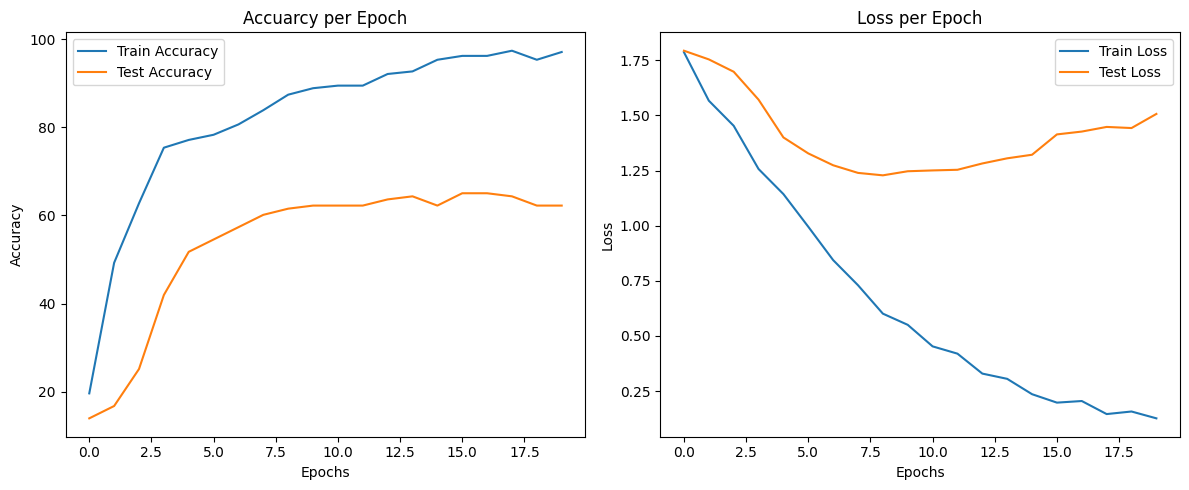

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset
train_dir = "CK_dataset/train"
test_dir = "CK_dataset/test"

# Minimal transforms with light augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Mild augmentation
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# EfficientNet-B1 with mild dropout
efficientnet_model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Mild dropout
    nn.Linear(num_features, 6)  # 6 classes
)

# Compute class weights
labels = np.array([label for _, label in train_dataset.samples])
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

efficientnet_model.to(device)

# Loss and optimizer with light weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training setup
num_epochs = 20
best_acc = 0.0
patience = 5
counter = 0

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Evaluation
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss_avg = test_loss / len(test_loader)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss_avg)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss_avg:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, '
          f'F1: {f1:.4f}')

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        torch.save(efficientnet_model.state_dict(), "best_efficientnet_b1_ck.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Final evaluation
efficientnet_model.load_state_dict(torch.load("best_efficientnet_b1_ck.pth"))
efficientnet_model.eval()

correct_final = 0
total_final = 0
test_loss_final = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        test_loss_final += loss.item()
        _, predicted = outputs.max(1)
        total_final += labels.size(0)
        correct_final += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = 100 * correct_final / total_final
final_test_loss = test_loss_final / len(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Classification report
class_names = train_dataset.classes  # Get class names from dataset
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Summary
print("\n" + "="*50)
print("Training Completed - Final Evaluation")
print("="*50)
print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")
print(f"Final Model Performance (Loaded Best Model):")
print(f"  Test Accuracy: {final_accuracy:.2f}%")
print(f"  Test Loss: {final_test_loss:.4f}")
print(f"  Precision (weighted): {precision:.4f}")
print(f"  Recall (weighted): {recall:.4f}")
print(f"  F1-Score (weighted): {f1:.4f}")

print("\nTraining Statistics Summary:")
print(f"  Final Train Accuracy: {train_acc_list[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_acc_list[-1]:.2f}%")
print(f"  Final Train Loss: {train_loss_list[-1]:.4f}")
print(f"  Final Test Loss: {test_loss_list[-1]:.4f}")
print(f"  Overfitting Indicator (Train - Test Acc): {(train_acc_list[-1] - test_acc_list[-1]):.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuarcy per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.tight_layout()
plt.show()

Using device: cuda
Epoch [1/20], Train Loss: 1.8090, Test Loss: 1.7950, Train Acc: 17.19%, Test Acc: 16.36%, F1: 0.0460
New best model saved with accuracy: 16.36%
Epoch [2/20], Train Loss: 1.6706, Test Loss: 1.7635, Train Acc: 35.94%, Test Acc: 16.36%, F1: 0.0460
No improvement. Patience counter: 1/5
Epoch [3/20], Train Loss: 1.5710, Test Loss: 1.7201, Train Acc: 48.44%, Test Acc: 18.18%, F1: 0.1438
New best model saved with accuracy: 18.18%
Epoch [4/20], Train Loss: 1.4606, Test Loss: 1.6976, Train Acc: 60.16%, Test Acc: 21.82%, F1: 0.1920
New best model saved with accuracy: 21.82%
Epoch [5/20], Train Loss: 1.3444, Test Loss: 1.6797, Train Acc: 74.22%, Test Acc: 29.09%, F1: 0.2479
New best model saved with accuracy: 29.09%
Epoch [6/20], Train Loss: 1.2700, Test Loss: 1.6632, Train Acc: 78.91%, Test Acc: 29.09%, F1: 0.2381
No improvement. Patience counter: 1/5
Epoch [7/20], Train Loss: 1.1379, Test Loss: 1.6407, Train Acc: 82.81%, Test Acc: 32.73%, F1: 0.2819
New best model saved with 

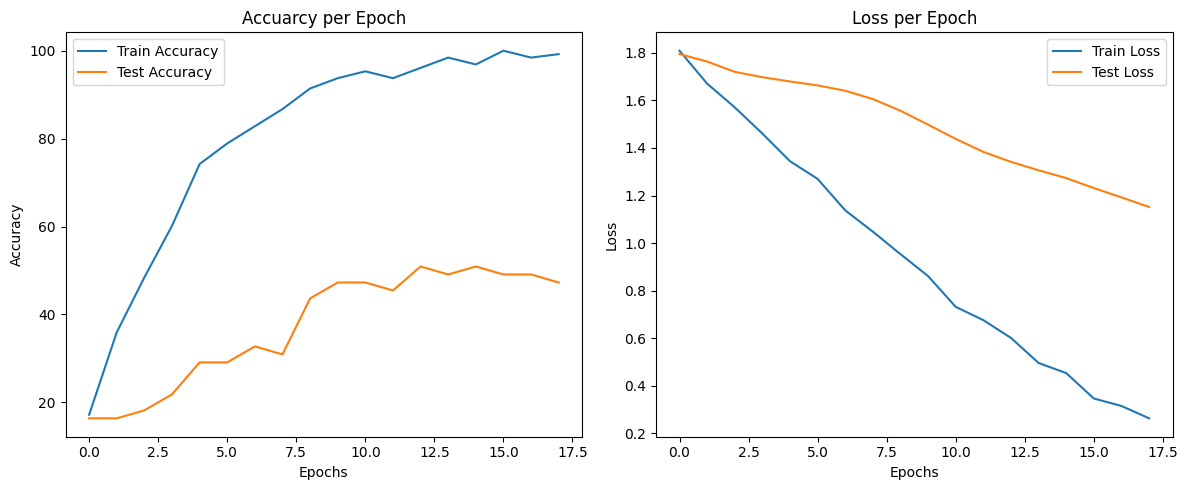

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset
train_dir = "JAFFE-[70,30]/train"
test_dir = "JAFFE-[70,30]/test"

# Minimal transforms with light augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Mild augmentation
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# EfficientNet-B1 with mild dropout
efficientnet_model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Mild dropout
    nn.Linear(num_features, 6)  # 6 classes
)

# Compute class weights
labels = np.array([label for _, label in train_dataset.samples])
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

efficientnet_model.to(device)

# Loss and optimizer with light weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training setup
num_epochs = 20
best_acc = 0.0
patience = 5
counter = 0

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Evaluation
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss_avg = test_loss / len(test_loader)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss_avg)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss_avg:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, '
          f'F1: {f1:.4f}')

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        torch.save(efficientnet_model.state_dict(), "best_efficientnet_b1_jaffe.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Final evaluation
efficientnet_model.load_state_dict(torch.load("best_efficientnet_b1_jaffe.pth"))
efficientnet_model.eval()

correct_final = 0
total_final = 0
test_loss_final = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        test_loss_final += loss.item()
        _, predicted = outputs.max(1)
        total_final += labels.size(0)
        correct_final += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = 100 * correct_final / total_final
final_test_loss = test_loss_final / len(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Classification report
class_names = train_dataset.classes  # Get class names from dataset
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Summary
print("\n" + "="*50)
print("Training Completed - Final Evaluation")
print("="*50)
print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")
print(f"Final Model Performance (Loaded Best Model):")
print(f"  Test Accuracy: {final_accuracy:.2f}%")
print(f"  Test Loss: {final_test_loss:.4f}")
print(f"  Precision (weighted): {precision:.4f}")
print(f"  Recall (weighted): {recall:.4f}")
print(f"  F1-Score (weighted): {f1:.4f}")

print("\nTraining Statistics Summary:")
print(f"  Final Train Accuracy: {train_acc_list[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_acc_list[-1]:.2f}%")
print(f"  Final Train Loss: {train_loss_list[-1]:.4f}")
print(f"  Final Test Loss: {test_loss_list[-1]:.4f}")
print(f"  Overfitting Indicator (Train - Test Acc): {(train_acc_list[-1] - test_acc_list[-1]):.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuarcy per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.tight_layout()
plt.show()

Final Test Accuracy: 66.43%


<Figure size 800x600 with 0 Axes>

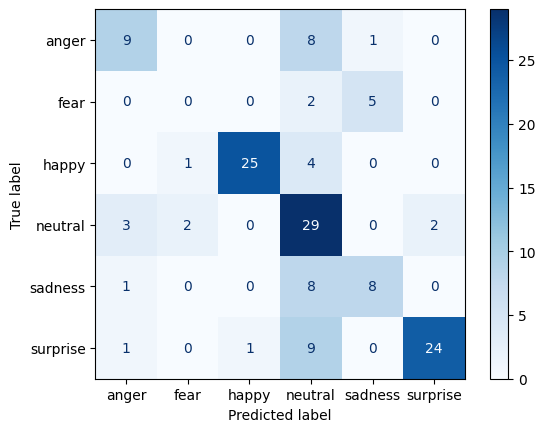

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
efficientnet_model.eval()
y_true = []
y_pred = []
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = efficientnet_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
final_test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=train_dataset.classes)

plt.figure(figsize=(8, 6))
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

Probabilities: tensor([[0.0161, 0.0018, 0.9411, 0.0019, 0.0038, 0.0352]], device='cuda:0')
Predicted class: happy


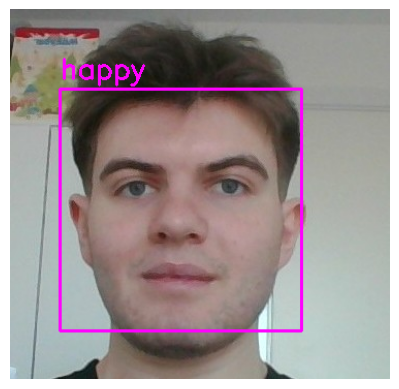

In [17]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


# Define prediction transforms matching training
predict_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to detect face
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None, None
    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    return face, (x, y, w, h)

# Load the image
image = cv2.imread("images/simon1.jpg")
face, bbox = detect_face(image)

if face is None:
    print("No face detected!")
else:
    # Draw rectangle around the detected face
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 255), 2)

    # Convert and preprocess face
    face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    face_tensor = predict_transforms(face_pil).unsqueeze(0).to(device)

    # Get prediction
    efficientnet_model.eval()
    with torch.no_grad():
        outputs = efficientnet_model(face_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        print("Probabilities:", probabilities)
        _, predicted = outputs.max(1)
        predicted_class = train_dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

    # Overlay prediction on image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.putText(image_rgb, predicted_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 255), 2)

    # Display
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()